# Lecture 1: Introduction to Bayesian Statistics
Scott Linderman <br>
March 24, 2022

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slinderman/stats305c/blob/master/notebooks/lecture1-normal-models.ipynb)



In [1]:
import torch
from torch.distributions import Normal, Gamma, StudentT, TransformedDistribution
from torch.distributions.transforms import PowerTransform
torch.manual_seed(305)

import matplotlib.pyplot as plt
from matplotlib.cm import Blues
import seaborn as sns
sns.set_context("talk")

## Normal Model with Unknown Mean

**Example:** Modeling SAT scores.
Suppose we have scores of $N$ students from one class. Assume the scores are well modeled as Gaussian random variables and that they are conditionally independent given the mean and variance. For now, assume we know the variance but not the mean.
 
**Notation:** Let,
- $x_n \in \mathbb{R}$ denote the score of the $n$-th student,
- $\mu \in \mathbb{R}$ denote the (unknown) mean of the distribution, and
- $\sigma^2 \in \mathbb{R}_+$ denote the (known) variance of the distribution.
- $\mu_0, \sigma_0^2$ denote the mean and variance of the Gaussian prior on $\mu$. 

**Model:**
\begin{align}
\mu &\sim \mathcal{N}(\mu_0, \sigma_0^2) \\
x_n \mid \mu, \sigma^2 &{\sim} \mathcal{N}(\mu, \sigma^2)  \quad  \text{for } n =1, \ldots, N
\end{align}

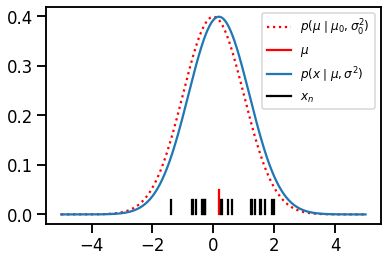

In [2]:
# Set model hyperparameters
mu0 = torch.tensor(0.0)
sigmasq0 = torch.tensor(1.0)
sigmasq = torch.tensor(1.0)

# Simulate data
N = 20
mu = Normal(mu0, torch.sqrt(sigmasq0)).sample()
X = Normal(mu, torch.sqrt(sigmasq)).sample(sample_shape=(N,))

# Plot 
prior = Normal(mu0, torch.sqrt(sigmasq0))
lkhd = Normal(mu, torch.sqrt(sigmasq))
grid = torch.linspace(-5, 5, 500)

plt.plot(grid, torch.exp(prior.log_prob(grid)), 
        ':r', label="$p(\mu \mid \mu_0, \sigma_0^2)$")
plt.plot([mu, mu], [0, 0.05], '-r', label="$\mu$")
plt.plot(grid, torch.exp(lkhd.log_prob(grid)), 
            label="$p(x \mid \mu, \sigma^2)$")
for n, x in enumerate(X):
    plt.plot([x, x], [0, 0.03], '-k', label="$x_n$" if n == 0 else None)
plt.legend(fontsize=12)

### Compute the posterior 

**Goal:** Infer $p(\mu \mid X, \eta)$, the posterior distribution over model parameters given  data and hyperparameters $\eta = (\sigma^2, \mu_0, \sigma_0^2)$.
\begin{align}
  p(\mu \mid X, \eta) &\propto
  p(\mu \mid \eta) \prod_{n=1}^N p(x_n \mid \mu, \eta) \\
  &= \mathcal{N}(\mu \mid \mu_0, \sigma_0^2) \prod_{n=1}^N \mathcal{N}(x_n \mid \mu, \sigma^2) \\
  &\propto \exp \left\{ -\frac{1}{2 \sigma_0^2} (\mu - \mu_0)^2 \right\} \prod_{n=1}^N \exp \left\{ -\frac{1}{2 \sigma^2} (x_n - \mu)^2 \right\} \\
  &\propto
  \exp \left\{ -\frac{1}{2} J_N \mu^2 + h_N \mu \right\}
\end{align}
where
\begin{align}
  J_N = \frac{1}{\sigma_0^2} + \frac{N}{\sigma^2} \quad \text{and} \quad
  h_N = \frac{\mu_0}{\sigma_0^2} + \sum_{n=1}^N \frac{x_n}{\sigma^2} 
\end{align}

**Completing the square:** Show that
\begin{align}
  \exp\left\{-\frac{1}{2} J_N \mu^2 + h_N \mu \right\} &\propto
  %\exp \left\{-\frac{1}{2\tilde{\sigma}^2} (\mu - \tilde{\mu})^2 \right\}
  \mathcal{N}(\mu \mid \mu_N, \sigma_N^2)
\end{align}
where $\sigma_N^2 = J_N^{-1}$ and $\mu_N = J_N^{-1} h_N$.

Thus, $p(\mu \mid X, \eta) = \mathcal{N}(\mu \mid \mu_N, \sigma_N^2)$
  where
  \begin{align}
    \mu_N &= \frac{\sigma_0^2 \sigma^2}{\sigma^2 + N \sigma_0^2} \left( \frac{\mu_0}{\sigma_0^2} + \frac{1}{\sigma^2} \sum_{n=1}^N x_n \right) \\
    &= \frac{\sigma^2}{\sigma^2 + N\sigma_0^2} \mu_0 + \frac{N\sigma_0^2}{\sigma^2 + N\sigma_0^2} \mu_{\mathsf{ML}}.
  \end{align}
  and $\mu_{\mathsf{ML}} = \frac{1}{N} \sum_{n=1}^N x_n$ is the maximum likelihood estimate.

In [3]:
# Compute the posterior p(\mu \mid X, \eta).
J_N = 1/sigmasq0 + N / sigmasq
h_N = mu0 / sigmasq0 + torch.sum(X / sigmasq)
mu_N = h_N / J_N
sigmasq_N = 1 / J_N
print("mu_N:     ", mu_N)
print("X.mean(): ", X.mean())

mu_N:      tensor(0.4590)
X.mean():  tensor(0.4819)


Plot the prior, likelihood, and posterior

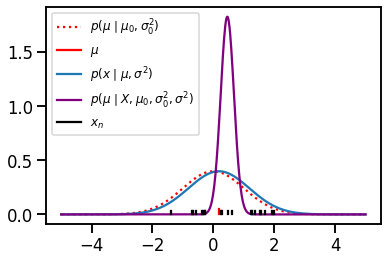

In [4]:
prior = Normal(mu0, torch.sqrt(sigmasq0))
lkhd = Normal(mu, torch.sqrt(sigmasq))
post = Normal(mu_N, torch.sqrt(sigmasq_N))
grid = torch.linspace(-5, 5, 500)

plt.plot(grid, torch.exp(prior.log_prob(grid)), 
        ':r', label="$p(\mu \mid \mu_0, \sigma_0^2)$")
plt.plot([mu, mu], [0, 0.05], '-r', label="$\mu$")
plt.plot(grid, torch.exp(lkhd.log_prob(grid)), 
            label="$p(x \mid \mu, \sigma^2)$")
plt.plot(grid, torch.exp(post.log_prob(grid)), color='purple',
         label="$p(\mu \mid X, \mu_0, \sigma_0^2, \sigma^2)$")
for n, x in enumerate(X):
    plt.plot([x, x], [0, 0.03], '-k', label="$x_n$" if n == 0 else None)
plt.legend(fontsize=12)

## Warm-up: Normal Model with Unknown Precision

Now suppose we know the mean $\mu$ but not the variance $\sigma^2$.
Our calculations will be a little simpler if we work with the _precision_ instead, $\lambda = 1/\sigma^2$.
Then,
\begin{align}
p(x \mid \mu, \lambda) &=
\left(\frac{\lambda}{2 \pi} \right)^{\frac{1}{2}} \exp \left\{-\frac{\lambda}{2} (x-\mu)^2 \right\}
\end{align}

The conjugate prior is a scaled chi-squared distribution, 
\begin{align}
\lambda \sim \chi^2(\nu_0, \lambda_0)
\end{align}
where $\chi^2$ denotes the scaled chi-squared distribution with density,
\begin{align}
    \chi^2(\lambda \mid \nu_0, \lambda_0) &=
     \frac{\left(\frac{\nu_0}{2\lambda_0}\right)^{\nu_0/2}}{\Gamma(\frac{\nu_0}{2})} \lambda^{\frac{\nu_0}{2} - 1} \exp\left\{-\frac{\lambda}{2}\frac{\nu_0}{\lambda_0} \right\}.
\end{align}

Since the scaled chi-squared distribution is non-standard (not in torch) we'll write our own. It's just a reparameterization of the gamma distribution, after all. Specifically,
\begin{align}
\chi^2(\nu_0, \lambda_0) \equiv \mathrm{Ga}(\tfrac{\nu_0}{2}, \tfrac{\nu_0}{2\lambda_0}),
\end{align}
where the $\nu_0/2$ is the shape and $\nu_0 / (2\lambda_0)$ is the _rate_ of the gamma distribution.

In [5]:
class ScaledChiSq(Gamma):
    def __init__(self, dof, scale):
        Gamma.__init__(self, dof / 2, dof / (2 * scale))
        self.dof = dof
        self.scale = scale

def sample_sum_sq(dof, scale, size=1):
    """
    Sample scaled chi squared random variables by taking the mean of squared 
    normal random variates, as presented in the notes.
    """
    zs = Normal(0, torch.sqrt(scale)).sample((size, int(dof)))
    return torch.mean(zs**2, axis=1)


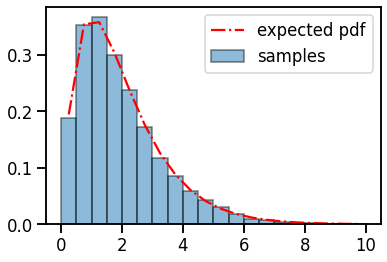

In [6]:
# Check that the pdf matches the empirical distribution of samples
dof = torch.tensor(4)
scale = torch.tensor(2.0)
chisq = ScaledChiSq(dof, scale)
lmbdas = sample_sum_sq(dof, scale, size=10000)

# Plot the pdf and the histogram of samples
bins = torch.linspace(0, 5 * chisq.scale, 21)
centers = (bins[:-1] + bins[1:]) / 2.0
plt.hist(lmbdas, bins, density=True, alpha=0.5, ec='k', label='samples')
plt.plot(centers, torch.exp(chisq.log_prob(centers)), 
         '-.r', label='expected pdf')
plt.legend()

Plot the density for a range of dof's

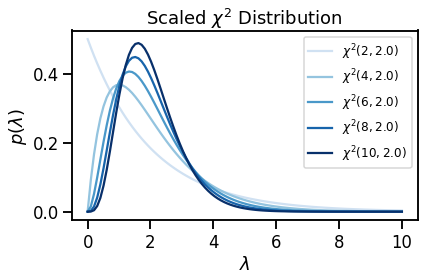

In [7]:
# Fix the scale and vary the degrees of freedom. 
# Evaluate the pdf on a dense grid.
scale = torch.tensor(2.)
grid = torch.linspace(1e-3, 10, 100)
dofs = torch.tensor([2, 4, 6, 8, 10])
for i, dof in enumerate(dofs):
    chisq = ScaledChiSq(dof, scale)
    plt.plot(grid, torch.exp(chisq.log_prob(grid)), 
             label="$\chi^2({}, {})$".format(dof, scale),
             color=Blues((i+1) / len(dofs)))

plt.legend(fontsize=12)
plt.xlabel("$\lambda$")
plt.ylabel("$p(\lambda)$")
plt.title("Scaled $\chi^2$ Distribution")

plt.tight_layout()

### Exercise: Write code to compute the posterior of the precision given the data

In [8]:
### Your code here

## Normal Model with Unknown Variance

If the precision $\lambda \sim \chi^2(\nu_0, \lambda_0)$, then the variance $\sigma^2 = 1/\lambda$ is a scaled inverse $\chi^2$ random variable,
  \begin{align}
    \sigma^2 &\sim \chi^{-2}(\nu_0, \sigma_0^2)
  \end{align}
  where $\sigma_0^2 = 1/\lambda_0$.

Its pdf can be found with the change of measure formula. Let $f(\sigma^2) = 1/\sigma^2$.
  \begin{align}
    \chi^{-2}(\sigma^2 \mid \nu_0, \sigma_0^2) 
    &= \left| \frac{\mathrm{d} f(\sigma^2)}{\mathrm{d} \sigma^2} \right| \chi^2(f(\sigma^2) \mid \nu_0, 1/\sigma_0^2)  \\
    &=  \frac{\left(\frac{\nu_0 \sigma_0^2}{2} \right)^{\nu_0/2}}{\Gamma(\frac{\nu_0}{2})} (\sigma^2)^{-\frac{\nu_0}{2} - 1} e^{-\frac{\nu_0 \sigma_0^2}{2 \sigma^2}} \\
  \end{align}
  The scaled inverse chi-squared is a special case of the inverse gamma distribution,~$\chi^{-2}(\nu_0, \sigma_0^2) \equiv \mathrm{IGa}(\tfrac{\nu_0}{2}, \tfrac{\nu_0 \sigma_0^2}{2})$, again using the rate parameterization.

Since torch does not have an inverse gamma distribution class, we use the `torch.distributions.transforms` objects to implement the scaled inverse chi-squared distribution as a transformation of a gamma random variable.

In [9]:
class ScaledInvChiSq(TransformedDistribution):
    """
    Implementation of the scaled inverse \chi^2 distribution defined in class.
    We will implement it as a transformation of a gamma distribution.
    """
    def __init__(self, dof, scale):
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

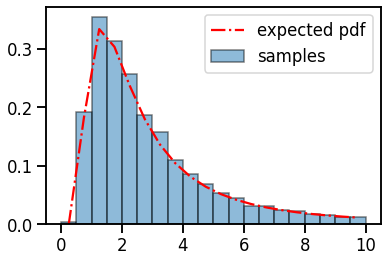

In [10]:
# Check that the pdf matches the empirical distribution of samples
inv_chisq = ScaledInvChiSq(4.0, 2.0)
sigmasqs = inv_chisq.sample(sample_shape=(10000,))

# Plot the pdf and the histogram of samples
bins = torch.linspace(0, 5 * inv_chisq.scale, 21)
centers = (bins[:-1] + bins[1:]) / 2.0
plt.hist(sigmasqs, bins, density=True, alpha=0.5, ec='k', label='samples')
plt.plot(centers, torch.exp(inv_chisq.log_prob(centers)), 
         '-.r', label='expected pdf')
plt.legend()

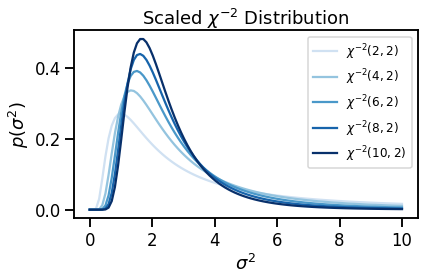

In [11]:
# Fix the scale and vary the degrees of freedom. 
# Evaluate the pdf on a dense grid.
scale = torch.tensor(2)
grid = torch.linspace(1e-3, 10, 100)
dofs = torch.tensor([2, 4, 6, 8, 10])
for i, dof in enumerate(dofs):
    inv_chisq = ScaledInvChiSq(dof, scale)
    plt.plot(grid, torch.exp(inv_chisq.log_prob(grid)), 
             label="$\chi^{{-2}}({}, {})$".format(dof, scale),
             color=Blues((i+1) / len(dofs)))

plt.legend(fontsize=12)
plt.xlabel("$\sigma^2$")
plt.ylabel("$p(\sigma^2)$")
plt.title("Scaled $\chi^{-2}$ Distribution")

plt.tight_layout()

### Exercise: Compute the posterior distribution of the variance given the data

In [14]:
### Your code here

## Normal Model with Unknown Mean and Variance

Finally, let's assume both the mean and the variance are unknown.
  Then, the conjugate prior is a _normal inverse chi-squared_ (NIX) distribution.
  \begin{align}
    p(\mu, \sigma^2) &= p(\sigma^2) \, p(\mu \mid \sigma^2) \\
    &= 
    \chi^{-2}(\sigma^2 \mid \nu_0, \sigma_0^2) \, \mathcal{N}(\mu \mid \mu_0, \sigma^2 / \kappa_0) \\
    &\triangleq \mathrm{NIX}(\mu, \sigma^2 \mid \mu_0, \kappa_0, \nu_0, \sigma_0^2)
  \end{align}

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


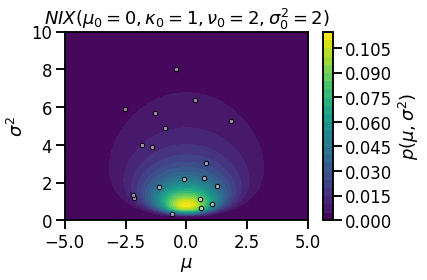

In [12]:
# Set NIX hypers
mu0 = torch.tensor(0.)
kappa0 = torch.tensor(1.0)
nu0 = torch.tensor(2.0)
sigmasq0 = torch.tensor(2.0)

# Evaluate the density on a grid
mu_grid, sigmasq_grid = \
    torch.meshgrid(torch.linspace(-5, 5, 50), 
                   torch.linspace(1e-3, 10, 50))
log_prob = ScaledInvChiSq(nu0, sigmasq0).log_prob(sigmasq_grid)
# note that the following line broadcasts over the grid of sigmasq!
log_prob += Normal(mu0, torch.sqrt(sigmasq_grid / kappa0)).log_prob(mu_grid)
plt.contourf(mu_grid, sigmasq_grid, torch.exp(log_prob), 25)

# Draw samples
def sample_nix(mu0, kappa0, nu0, sigmasq0, size):
    sigmasq = ScaledInvChiSq(nu0, sigmasq0).sample(sample_shape=(size,))
    # Sample the mean (note the broadcasting with a vector of sigmasq!)
    mu = Normal(mu0, torch.sqrt(sigmasq / kappa0)).sample()
    return mu, sigmasq

# Plot the samples
mu, sigmasq = sample_nix(mu0, kappa0, nu0, sigmasq0, 25)
plt.plot(mu, sigmasq, 'w.', markeredgecolor='k', markerfacecolor=[1,1,1,.5])
plt.xlim(-5, 5)
plt.ylim(0, 10)
plt.xlabel("$\mu$")
plt.ylabel("$\sigma^2$")
plt.title(r"$NIX(\mu_0={:.0f}, \kappa_0={:.0f}, \nu_0={:.0f}, \sigma_0^2={:.0f})$"\
          .format(mu0, kappa0, nu0, sigmasq0))
plt.colorbar(label='$p(\mu, \sigma^2)$')
plt.tight_layout()

### Exercise: Compute the NIX posterior over the mean and variance given data

In [15]:
### Your code here

### Finally, plot the marginals of the NIX distribution

The marginal distribution of the mean is $\mu \sim \mathrm{St}(\nu, \mu, \sigma^2 / \kappa)$

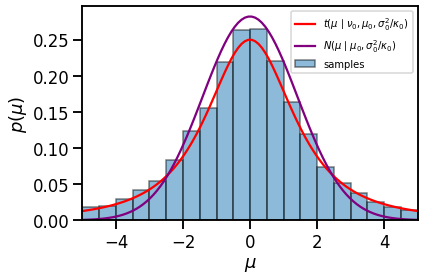

In [13]:
mu_marginal = StudentT(nu0, mu0, torch.sqrt(sigmasq0 / kappa0))

# Draw more samples
mu, _ = sample_nix(mu0, kappa0, nu0, sigmasq0, 10000)

# Check that the sample histogram matches the pdf
mu_grid = torch.linspace(-5, 5, 100)
bins = torch.linspace(-5, 5, 21)
centers = (bins[:-1] + bins[1:]) / 2.0
plt.hist(mu, bins, density=True, alpha=0.5, ec='k', label='samples')
plt.plot(mu_grid, torch.exp(mu_marginal.log_prob(mu_grid)), 
         '-r', label=r'$t(\mu \mid \nu_0, \mu_0, \sigma_0^2/\kappa_0)$')
plt.plot(mu_grid, torch.exp(
    Normal(mu0, torch.sqrt(sigmasq0 / kappa0)).log_prob(mu_grid)), 
         color='purple', label='$N(\mu \mid \mu_0, \sigma_0^2 / \kappa_0)$')
plt.legend(fontsize=10)
plt.xlim(-5, 5)
plt.xlabel("$\mu$")
plt.ylabel("$p(\mu)$")
plt.tight_layout()

## Recap
This notebook covered Bayesian analysis of scalar Gaussian models with unknown mean and/or variance/precision. It also showed how to do a bunch of things in Python and PyTorch:
- Working with PyTorch `tensor`s (instead of numpy arrays)
- Using PyTorch `Distribution` objects
- Creating new `Distribution`s by inheritance
- Using the `TransformedDistribution` and `torch.distributions.transforms`
- Plotting with matplotlib
- Mixing math and code in Jupyter notebooks